## 1 Data and package import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2 Data Inspection

### 2.1 Checking data types

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 2.2 Transforming data

In [7]:
#Change values 0 and 1 to Yes and No in SeniorCitizen for consistent scaling
data['SeniorCitizen'] = data['SeniorCitizen'].map({1:'Yes',0:'No'})

#Change type of TotalCharges from object to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

### 2.3 Checking levels in categorical variables

In [8]:
for col in data.columns[1:]:
    if data[col].dtype == 'object':
        print(f'{col} {data[col].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


### 2.4 Checking missing values

In [9]:
#Check NA´s
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
#Inspect NA´s in dataframe
# data[data.TotalCharges.isna()]

In [11]:
#Insprect total charges when tenure=1
# data[data.tenure == 1]

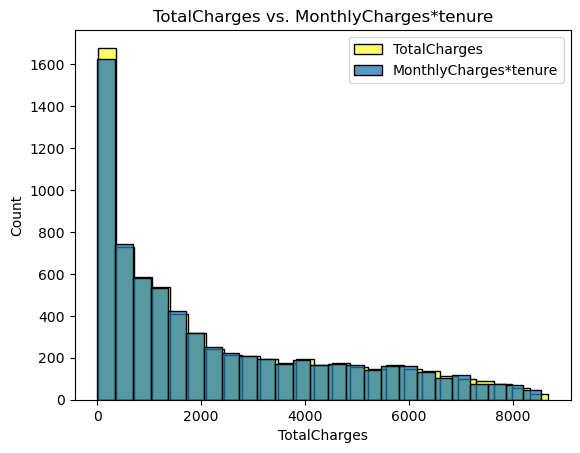

In [12]:
#Relationship total charges with monthlycharges * tenure
sns.histplot(data.TotalCharges, color='yellow',alpha=0.6,label='TotalCharges')
sns.histplot(data.MonthlyCharges*data.tenure,label='MonthlyCharges*tenure')
plt.title('TotalCharges vs. MonthlyCharges*tenure')
plt.legend()
plt.show()

In [13]:
#Replace monthly and total charges values with 0 where tenure = 0
data.loc[data['tenure'] == 0, 'MonthlyCharges'] = 0
data.loc[data['TotalCharges'].isna(), 'TotalCharges'] = 0

All Na´s in total charges have a monthly charges of 0. When you check the total charges with tenure == 1, total charges is the product of monthly charges times tenure. Its unclear why customers with tenure = 0 already have monthly charges when the total charges with tenure = 1 is the same as in monthly charges. Therefore Na´s and monthly charges in tenure = 0 will be replaced by 0.

### 2.5 Checking duplicates

In [14]:
data.duplicated().sum()

0

### 2.6 Delete reduntant variables

In [15]:
#Delete customerID - reduntant variable
data = data.drop('customerID',axis=1)

## 3 Churn Analysis

### 3.1 Churn Rate

 Customers who have a one year contract churn within their minimal contract duration. Its unclear why. Therefore it is assumend that these customers are outliers and will be deleted for data consistency.

In [16]:
# Proportion of customers with a one year contract, which churn within minimal contract duration
np.divide(data[(data.tenure <= 12) & (data.Churn == 'Yes') & (data.Contract == 'One year')]['Contract'].count(),
          data[(data.Churn == 'Yes') & (data.Contract == 'One year')]['Contract'].count()).round(2)

0.08

In [17]:
# Delete customers with a one year contract and churn within minimal contract duration
data = data[~((data.tenure <= 12) & (data.Churn == 'Yes') & (data.Contract == 'One year'))]

In [18]:
#Total Churn (1st Level)
(data[data.Churn == 'Yes']['Churn'].count() / len(data)).round(2)

0.26

In [19]:
#Total Churn Rate per month
(data[data.Churn == 'Yes']['Churn'].count() / 72).round()


26.0

In [20]:
# Churn Rate per Contract type (2nd Level)
(data[data.Churn == 'Yes']['Contract'].value_counts() / data.Contract.value_counts()).round(2)

Contract
Month-to-month    0.43
One year          0.10
Two year          0.03
Name: count, dtype: float64

### 3.2 Churn among tenure and Contract Types

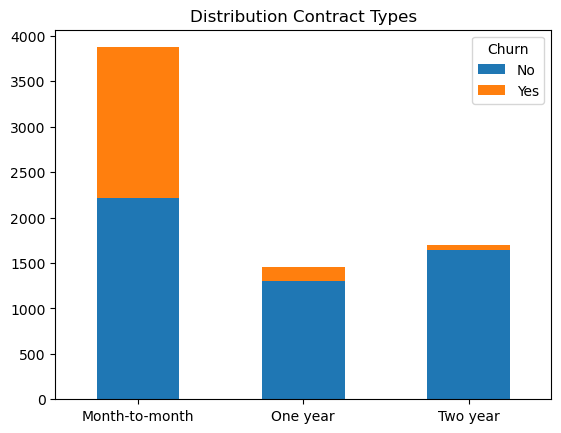

In [21]:
#Proportion contract types
data.groupby('Contract')['Churn'].value_counts().unstack().plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title('Distribution Contract Types')
plt.xlabel('')
plt.show()

In [22]:
data['Contract'].value_counts(normalize=True).round(2)

Contract
Month-to-month    0.55
Two year          0.24
One year          0.21
Name: proportion, dtype: float64

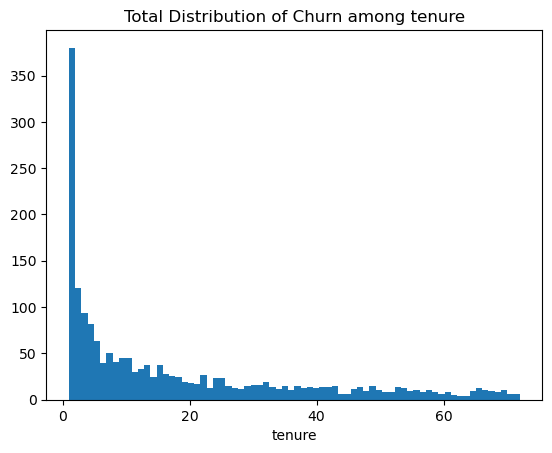

In [23]:
# Distribution churn among tenure
plt.hist(data=data[data.Churn == 'Yes'],x='tenure',bins=72)
plt.xticks(ticks=np.arange(min(data.tenure),max(data.tenure),3))
plt.title('Total Distribution of Churn among tenure')
plt.xlabel('tenure')
plt.xticks(ticks=np.arange(0,72,20))
# plt.grid(linestyle='--')
plt.show()

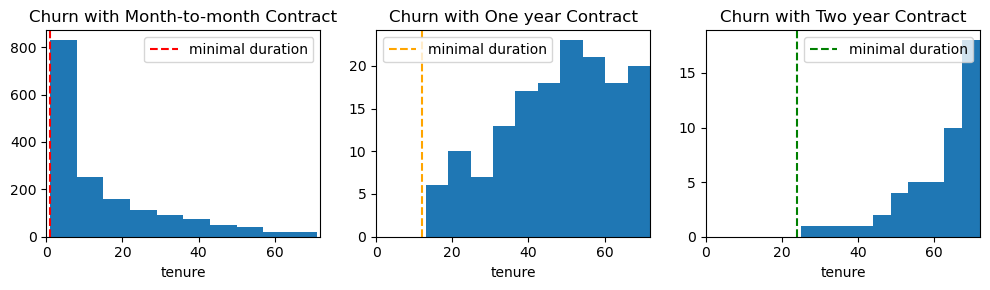

In [24]:
#Churn Distribution among Contract Types and
contract_types = ('Month-to-month','One year','Two year')

plt.figure(figsize=(10,3))
for i, contract_type in enumerate(contract_types):
    plt.subplot(1, 3, i + 1)
    plt.hist(data[(data.Churn == 'Yes') & (data.Contract == contract_type)]['tenure'], bins=10)
    plt.title(f'Churn with {contract_type} Contract')
    plt.xlabel('tenure')
    # plt.grid(linestyle='--')
    plt.xlim(0,72)

    if contract_type == 'Month-to-month':
        plt.axvline(1,color='red',linestyle='--',label='minimal duration')
    elif contract_type == 'One year':
        plt.axvline(12,color='orange',linestyle='--',label='minimal duration')
    else:
        plt.axvline(24,color='green',linestyle='--',label='minimal duration')
    plt.legend()
  
plt.tight_layout()
plt.show()

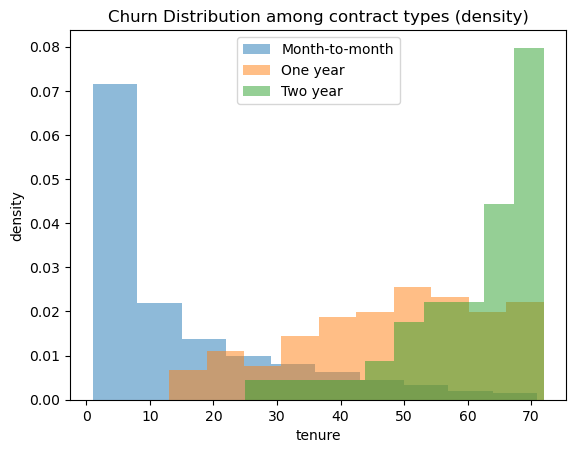

In [25]:
#Churn Distribution among contract types (density)
plt.hist(data=data[(data.Churn == 'Yes') & (data.Contract == 'Month-to-month')],x='tenure',bins=10,density=True,alpha=0.5,label='Month-to-month')
plt.hist(data=data[(data.Churn == 'Yes') & (data.Contract == 'One year')],x='tenure',bins=10,density=True,alpha=0.5,label='One year')
plt.hist(data=data[(data.Churn == 'Yes') & (data.Contract == 'Two year')],x='tenure',bins=10,density=True,alpha=0.5,label='Two year')
plt.title('Churn Distribution among contract types (density)')
plt.legend()
plt.ylabel('density')
plt.xlabel('tenure')

plt.show()

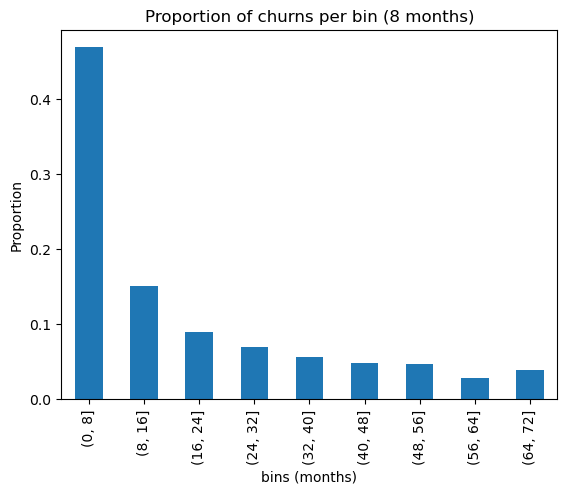

In [26]:
##Binning tenure to explore the proportion of churn per bin
data_bins = data.copy()
data_bins = data_bins[data_bins.Churn == 'Yes']
data_bins['tenure_bin'] = pd.cut(x=data_bins['tenure'],bins=np.arange(0,73,8))

data_bins.tenure_bin.value_counts(normalize=True).sort_index().plot.bar()
plt.title('Proportion of churns per bin (8 months)')
plt.ylabel('Proportion')
plt.xlabel('bins (months)')
plt.show()

In [27]:
data_bins.tenure_bin.value_counts(normalize=True).sort_index().round(2)

tenure_bin
(0, 8]      0.47
(8, 16]     0.15
(16, 24]    0.09
(24, 32]    0.07
(32, 40]    0.06
(40, 48]    0.05
(48, 56]    0.05
(56, 64]    0.03
(64, 72]    0.04
Name: proportion, dtype: float64

In [28]:
#Decription of contract types
for type in contract_types:
    print(f'{type}')
    print(data[(data.Contract == type) & (data.Churn == 'Yes')]['tenure'].describe().round())

Month-to-month
count    1655.0
mean       14.0
std        16.0
min         1.0
25%         2.0
50%         7.0
75%        21.0
max        71.0
Name: tenure, dtype: float64
One year
count    153.0
mean      48.0
std       16.0
min       13.0
25%       38.0
50%       51.0
75%       60.0
max       72.0
Name: tenure, dtype: float64
Two year
count    48.0
mean     61.0
std      11.0
min      25.0
25%      56.0
50%      66.0
75%      70.0
max      72.0
Name: tenure, dtype: float64


As shown in the description above, churns based on different time periods among the contract types. Customers who have a Month-to-month contract churn within a period of 70 months, customers who have a one year contract within 59 months and customers with a two year contract within 47 months.For this reason, churn among contract types must be defined per month to avoid a biased view.

In [29]:
# Churn Rate per contract type and month (3rd Level)
print('month_to_month_churn_per_month', np.round((1655 / (3875*70))*100,2))
print('one_year_churn_per_month', np.round((166 / (1495*70))*100,2))
print('two_year_churn_per_month', np.round((48 / (1695*47))*100,2))

month_to_month_churn_per_month 0.61
one_year_churn_per_month 0.16
two_year_churn_per_month 0.06


### 3.3 Churn among categorical variables

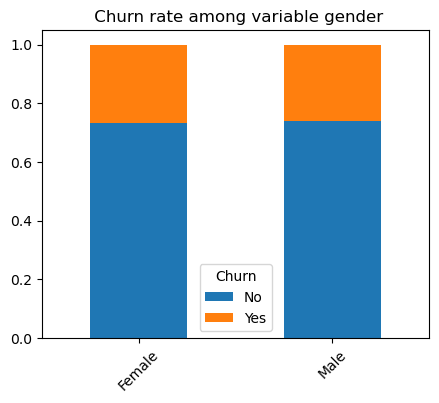

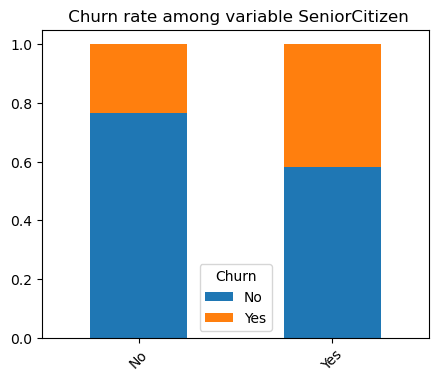

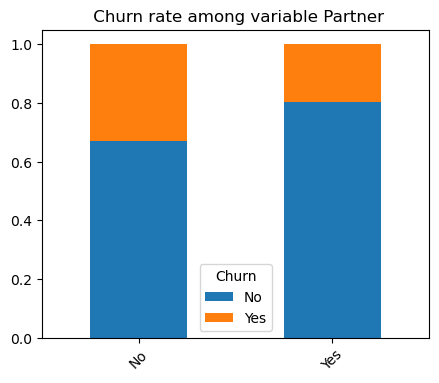

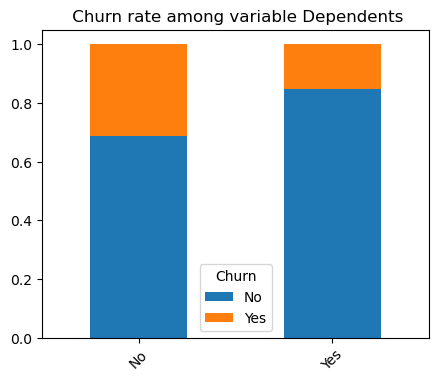

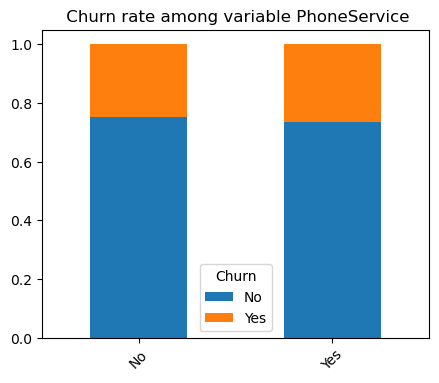

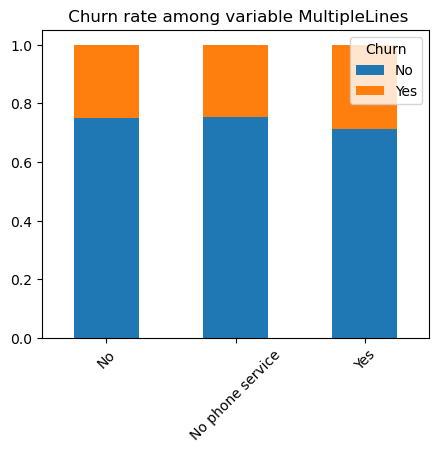

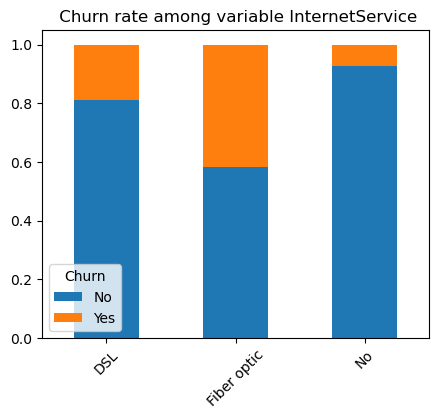

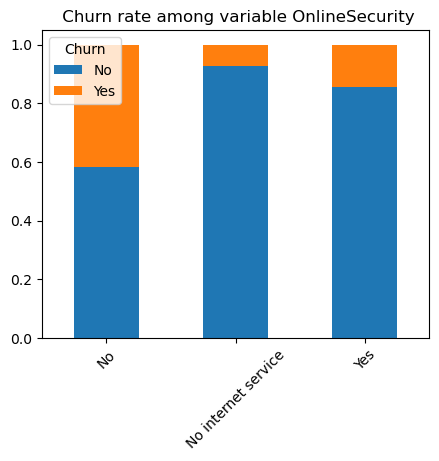

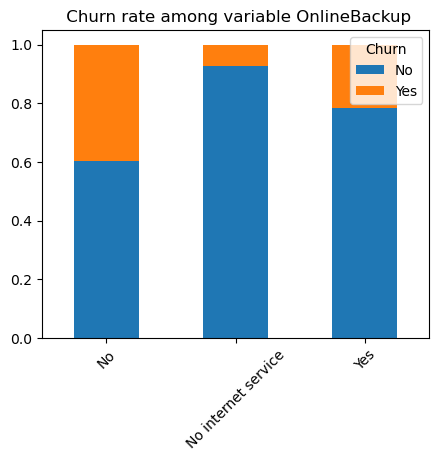

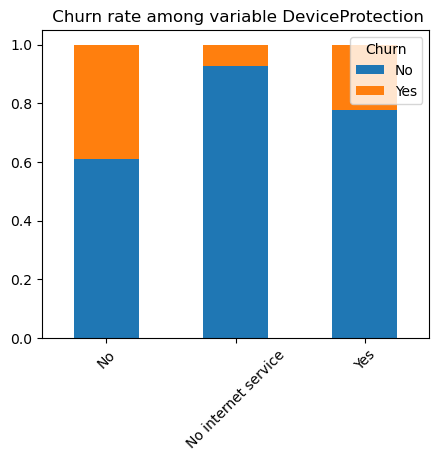

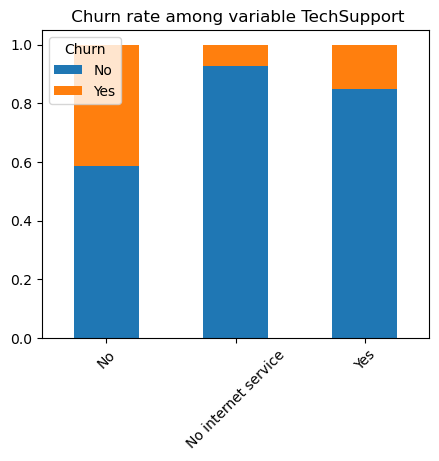

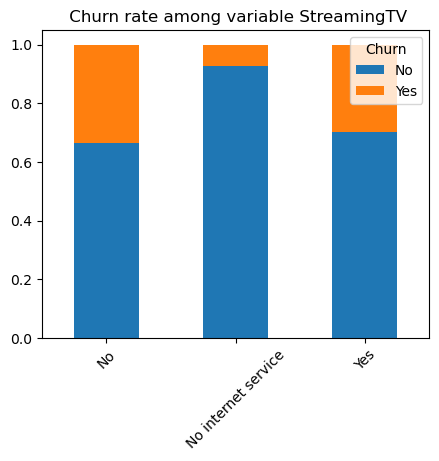

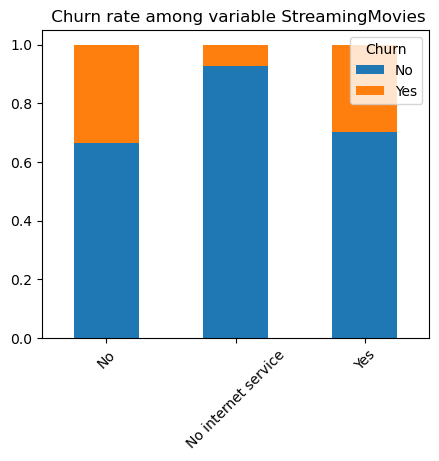

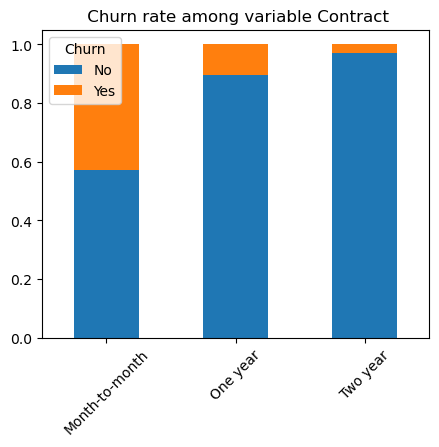

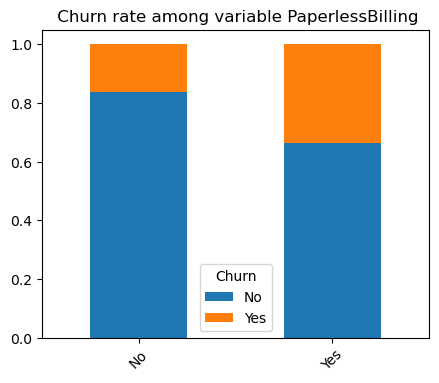

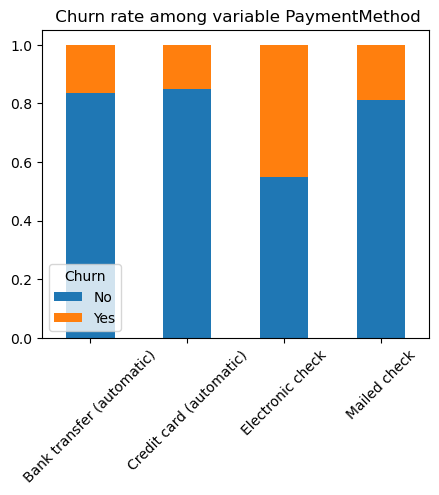

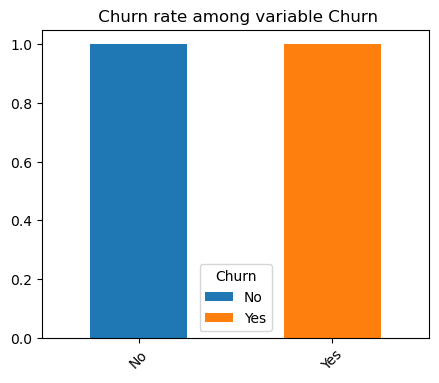

In [ ]:
for var in data.columns:
    if data[var].dtype == 'object':
        churn_distribution = data.groupby([var,'Churn'])[var].value_counts() #/ data[var].value_counts()
        churn_distribution.unstack().plot.bar(stacked=True,figsize=(5,4))
        plt.title(f' Churn rate among variable {var}')
        plt.xticks(rotation=45)
        plt.xlabel('')
        plt.show()

### 3.4 Correlation between categorical variables and churn

In [31]:
#Correlation between categorical variables and churn using Cramers V

from scipy.stats import chi2_contingency
# pd.set_option('display.float_format', '{:.4f}'.format)


results = []

for col in data.columns[:-1]:
    if data[col].dtype == 'object':

        #Chi2
        chi2_conting = pd.crosstab(data['Churn'],data[col])
        chi2,p,dof,expected = chi2_contingency(chi2_conting)
        # print(f'{col}')
        # print(f'p_value: {p}')

        # Cramers V
        n = chi2_conting.sum(axis=1).sum()
        r, k = chi2_conting.shape  
        m = min(r-1, k-1)
        v = np.sqrt(chi2 / (n * m))
        # print(f'Cramers V: {v} \n')

        #Append to list result
        results.append({'Cat_Var':col,'Cramers V':v.round(4),'p_value':p.round(4)})

#Create DataFrame
corr_cat_df = pd.DataFrame(results).sort_values(by='Cramers V',ascending=False).reset_index(drop=True)
corr_cat_df

,Cat_Var,Cramers V,p_value
0,Contract,0.4141,0.0000
1,OnlineSecurity,0.3481,0.0000
2,TechSupport,0.3445,0.0000
3,InternetService,0.3252,0.0000
4,PaymentMethod,0.3045,0.0000
5,OnlineBackup,0.2930,0.0000
6,DeviceProtection,0.2832,0.0000
7,StreamingMovies,0.2325,0.0000
8,StreamingTV,0.2322,0.0000
9,PaperlessBilling,0.1930,0.0000


## 4 Revenue Churn

In [32]:
#Revenue Churn Rate
(data[data.Churn == 'Yes']['TotalCharges'].sum()).round()

2857223.0

In [33]:
#Proportion of Revenue Churn Rate
(data[data.Churn == 'Yes']['TotalCharges'].sum() / data.TotalCharges.sum()).round(2)

0.18

In [34]:
#Revenue Churn Rate per month
(data[data.Churn == 'Yes']['TotalCharges'].sum() / 72).round()

39684.0

In [35]:
#Revenue Churn Rate per Contract
(data[data.Churn == 'Yes'].groupby('Contract')['TotalCharges'].sum()).round()

Contract
Month-to-month    1927182.0
One year           669287.0
Two year           260753.0
Name: TotalCharges, dtype: float64

In [36]:
data.to_csv('data_ml.csv')